# Lab 8: Spectral Factorizations

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import hann

# soundplayer function
def sound( x, rate=44100, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

In [2]:
# spectrograph function
dft_size_dflt = 1024
hop_size_dflt = 64
def stft( input_sound, numb_bins=dft_size_dflt//2+1, dft_size=dft_size_dflt, hop_size=hop_size_dflt, window=hann(dft_size_dflt)):
    if (input_sound.size%hop_size) != 0:
        input_sound = np.pad(input_sound, (0, hop_size-(input_sound.size%hop_size))) # pad input to hop size so last frame is full
    f = np.zeros(numb_bins) # initial matrix column
    current = 0
    while current <= (input_sound.size-dft_size):
        arg = input_sound[current:current+dft_size]
        dft = np.fft.rfft(window*arg, numb_bins*2-1)
        f = np.column_stack((f, dft))
        current += hop_size
    return f[:, 1:] # return a complex-valued spectrogram (frequencies x time)

In [3]:
# inverse spectrograph function
def istft( stft_output, dft_size=dft_size_dflt, hop_size=hop_size_dflt):
    numb_bins = stft_output.shape[0] # number of frequency bins in spectrogram # -1 for DC bin
    numb_dft = stft_output.shape[1] # number of dft slices in spectrogram
    f = np.zeros((numb_bins*2) + (numb_dft-1)*hop_size) # output array
    current = 0
    while current < (numb_dft):
        arg = stft_output[:, current]
        idft = np.fft.irfft(arg)
        f[current*hop_size : current*hop_size + idft.size] += idft
        current+=1
    return f[:dft_size+(numb_dft-1)*hop_size] # return a real-valued array of audio samples in time-domain

In [4]:
# load sound
drum_sr, drum = read('data/80s-hi.wav')
print(drum_sr)

44100


In [5]:
# stft
drum_stft = stft(drum)
print(drum_stft.shape)

(513, 1823)


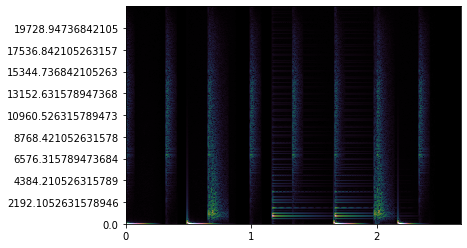

In [6]:
# normalize axes to Hz vs s
drum_hz2bin = (drum_stft.shape[0])*(drum_sr/2)
drum_xticks = np.arange(0, drum_stft.shape[1], drum_sr/(drum.size/drum_stft.shape[1]))
drum_xlabels = np.arange(drum_xticks.size)
drum_numb_yticks = 10;
drum_freq = np.fft.fftfreq((drum_stft.shape[0])*2)*drum_sr
drum_yticks = np.arange(0, drum_stft.shape[0], drum_stft.shape[0]/drum_numb_yticks)
drum_ylabels = drum_freq[:(drum_freq.size//2): drum_stft.shape[0]//drum_numb_yticks]

# plot spectrogram + play sound
plt.pcolormesh(abs(drum_stft**0.4), cmap='cubehelix')
plt.xticks(drum_xticks, drum_xlabels)
plt.yticks(drum_yticks, drum_ylabels)
ax = plt.gca()
#ax.set_xlim((110, 130))
#ax.set_ylim((0, 2000*drum_hz2bin))
plt.show()
sound(istft(drum_stft), rate=drum_sr)

## Part 1. Learning Spectral Components

In this part we will design a simple component analyzer. Use the sound file [https://drive.google.com/uc?export=download&id=1fyHhUqYVOrIPzSMJoQC78sqeokjqI4ib]. This is a drum loop with four distinct sounds (bass drum, snare drum, cymbal and synthetic bell sound). We will use a spectral factorization that will allow us to extract them all. Obtain the STFT of this signal and use a DFT size of 4096, a hop size of 256 and a Hann window. This will be stored in a matrix $\mathbf F$ whose size will be $M$ by $N$. 

You now need to implement a factorization technique. This is defined as:

$$|\mathbf F | \approx \mathbf{W} \cdot \mathbf{H}$$
$$\mathbf{F} \in \mathbb{R}^{M\times N}_+, \mathbf{W} \in \mathbb{R}^{M\times K}_+, \mathbf{H} \in \mathbb{R}^{K\times N}_+$$

Where $\mathbb{R}^{A\times B}_+$ is the set of matrices of size $A \times B$ containing non-negative elements, and $|\mathbf{F}|$ takes the absolute value of the STFT matrix $\mathbf{F}$.  In this case we will use $K$=4 since the mix we are analyzing has four distinct sounds.  To estimate the values of $\mathbf{W}$ and $\mathbf{H}$ start by filling them with uniformly random values between 10 to 11 and iterate over the following equations:

$$\mathbf{V} = \frac{|\mathbf{F}|}{\mathbf{W}\cdot \mathbf{H} + \epsilon}$$
$$\mathbf{H} = \mathbf{H} \odot \left[ \mathbf{W}^\top \cdot \mathbf{V} \right]$$
$$\mathbf{W} = \mathbf{W} \odot \left[ \mathbf{V} \cdot \mathbf{H}^\top \right]$$

Where $\odot$ denotes element-wise multiplication and the fraction performs element-wise division.  The constant $\epsilon$ is assigned to a small value (e.g. 1e-7) to avoid division by zero. After each pass normalize the columns of $\mathbf{W}$ to sum to 1.  Iterate for about 100 times.

Plot the columns of $\mathbf{W}$ and explain what they correspond to. Plot the rows of $\mathbf{H}$ and explain them as well. You might have to run the above procedure a couple of times since in some cases the results can come up wrong. Just to be safe, run this a dozen times and show the results that are representative of the majority of the outputs (note that each time the ordering will be different, we only care about the shapes of these quantities, not their order).

You can now try to extract each component. Take each column of $\mathbf{W}$ and compute its outer product with its corresponding row of $\mathbf{H}$. This will approximate only one component of the input spectrogram. Plot all four products and explain what they look like. Use the phase of the original input to invert these resulting spectrograms to the time domain and listen to them. What do they sound like?

frequency factors
      BELL ------ BASS ------ SNARE ------ HAT


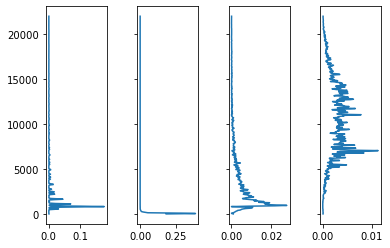

time factors
      BELL ------ BASS ------ SNARE ------ HAT


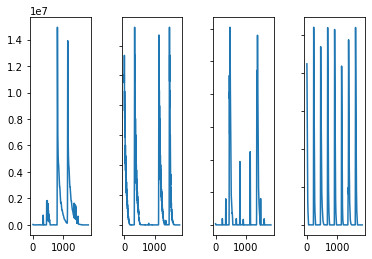

BELL


c:\users\thomas\.virtualenvs\labs-svz6oad0\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in power


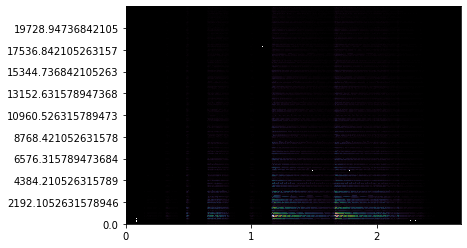

BASS


c:\users\thomas\.virtualenvs\labs-svz6oad0\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in power


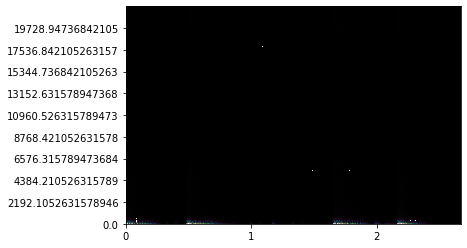

SNARE


c:\users\thomas\.virtualenvs\labs-svz6oad0\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in power


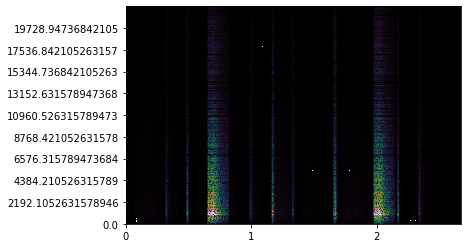

HAT


c:\users\thomas\.virtualenvs\labs-svz6oad0\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in power


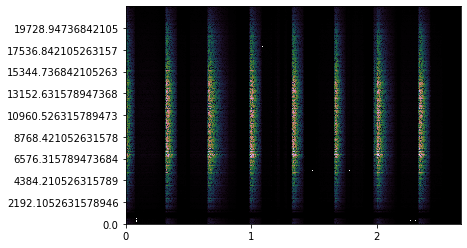

In [14]:
# define matrices
sr = drum_sr
F = drum_stft
M = F.shape[0]
N = F.shape[1]
K = 4
W = np.random.rand(M, K) + 10
H = np.random.rand(K, N) + 10
V = np.zeros((M, N))

# 1. each frequency/time factor set is applied at each pixel of the stft
# 2. a weight is assigned to each factor set that corresponds to the strength of that factor set's correlation with pixel
# 3. factors are iteratively reestimated by repeating and considering new weights
# 4. factor sets will converge to the K most unique sounds because of the weighting

# learn components
for i in range(100):
    V = abs(F) / ((W @ H) + 1e-7)
    H = H * (W.T @ V)
    W = W * (V @ H.T)
    for j in range(K):
        W[:, j] /= np.sum(W[:, j])
        
# plot frequency factors (columns of W)
print('frequency factors')
print('      BELL ------ BASS ------ SNARE ------ HAT')
fig, ax = plt.subplots(1, K)
for i in range(K):
    ax[i].plot(W[:, i], np.fft.fftfreq(M*2, 1/sr)[:M])
    ax[i].label_outer()
fig.subplots_adjust(wspace=.5)
plt.show()

# plot time factors (rows of H)
print('time factors')
print('      BELL ------ BASS ------ SNARE ------ HAT')
fig2, ax2 = plt.subplots(1, K)
for i in range(K):
    ax2[i].plot(H[i, :])
    ax2[i].label_outer()
fig2.subplots_adjust(wspace=.5)
plt.show()

# resynthesize components
phase = np.angle(F)
comp = np.zeros((K, M, N))
print(phase.shape)
print(W[:, 0, np.newaxis].shape)
print(H[np.newaxis, 0, :].shape)
for i in range(K):
    comp[i] = (W[:, i, np.newaxis] @ H[np.newaxis, i, :]) * (np.exp(1j * phase))
print(comp.shape)

# plot components
print('BELL')
plt.pcolormesh(abs(comp[0]**0.4), cmap='cubehelix')
plt.xticks(drum_xticks, drum_xlabels)
plt.yticks(drum_yticks, drum_ylabels)
plt.show()
sound(istft(comp[0]))
# BELL - the only component with obvious harmonic content, which you can see in the way the energy is concentrated 
# in frequencies at regular intervals (harmonic series)

print('BASS')
plt.pcolormesh(abs(comp[1]**0.4), cmap='cubehelix')
plt.xticks(drum_xticks, drum_xlabels)
plt.yticks(drum_yticks, drum_ylabels)
plt.show()
sound(istft(comp[1]))
# BASS - energy is concentrated only in the very lowest frequencies

print('SNARE')
plt.pcolormesh(abs(comp[2]**0.4), cmap='cubehelix')
plt.xticks(drum_xticks, drum_xlabels)
plt.yticks(drum_yticks, drum_ylabels)
plt.show()
sound(istft(comp[2]))
# SNARE - inharmonic content focused in the midrange. the strongest hits fall on the backbeat

print('HAT')
plt.pcolormesh(abs(comp[3]**0.4), cmap='cubehelix')
plt.xticks(drum_xticks, drum_xlabels)
plt.yticks(drum_yticks, drum_ylabels)
plt.show()
sound(istft(comp[3]))
# HAT - inharmonic content focused in the upper range which is typical for cymbals. also note the regular timing

## Part 2: Trainign Dictionaries for Source Separation

In this section we will design a system that separates speech of a known speaker from a known type of noise. Use the sound files [https://drive.google.com/uc?export=download&id=1fhTSrXDDbsp06oqlrBL9p9JToC4Mws11 ] and [https://drive.google.com/uc?export=download&id=1fmtVWSLp5ZB5_pkFvr8BEXSj0bRuNe70] from the lab archive.

One of them is of speech and the other one of chimes. Take the first sentence of the speech sound and a segment which is just as long from the beginning of the chime sound and add them together. This will be a mixture that we will try to separate. The rest of the data we will use for training dictionary models.
Taking the rest of the speech data run a factorization as we’ve done above with $K$ = 40. Do the same with the remaining chime sound. From these you will obtain two matrices $\mathbf{W}_s$ and $\mathbf{W}_c$. These are the dictionaries of the two sounds. If you visually inspect them you will see that they look a lot like representative spectra of these two sounds.

In order to resolve the mixture we need to use these dictionaries to explain its spectrogram and then only use each dictionary’s contribution to resynthesize a time signal. This essentially involves finding the $\mathbf{H}$ matrix while fixing the $\mathbf{W}$ matrix to be a concatenation of $\mathbf{W}_s$ and $\mathbf{W}_c$. You can do that using the iterative approach used in the previous part, but only updating $\mathbf{H}$ and not updating $\mathbf{W}$ at every iteration. If you do this on the mixture you will ultimately get a $\mathbf{H}$ that will let us know how to combine the elements of the pretrained dictionaries to approximate the input.

To extract the two sounds you need to isolate the contribution of the two dictionaries on the mixture. That will be $\mathbf{F}_s = \mathbf{W}_s \cdot \mathbf{H}_s$ and $\mathbf{F}_c = \mathbf{W}_c \cdot \mathbf{H}_c$, where $\mathbf{H}_s$ corresponds to the first 40 rows of $\mathbf{H}$ and $\mathbf{H}_c$ to its second 40 rows. $\mathbf{F}_s$ and $\mathbf{F}_c$  will correspond to the magnitude spectrograms of the two extracted sources. Just as before use the phase of the input mixture to invert these back to the time domain and listen to them. Do they sound like they are separated? Play around with the STFT parameters until you get the best sounding results.

In [8]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 